<a href="https://colab.research.google.com/github/Vidhan-152/Fashion-MNIST-Classifier/blob/main/FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
torch.manual_seed(42)

In [ ]:
# GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
df = pd.read_csv('fashion-mnist_train.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


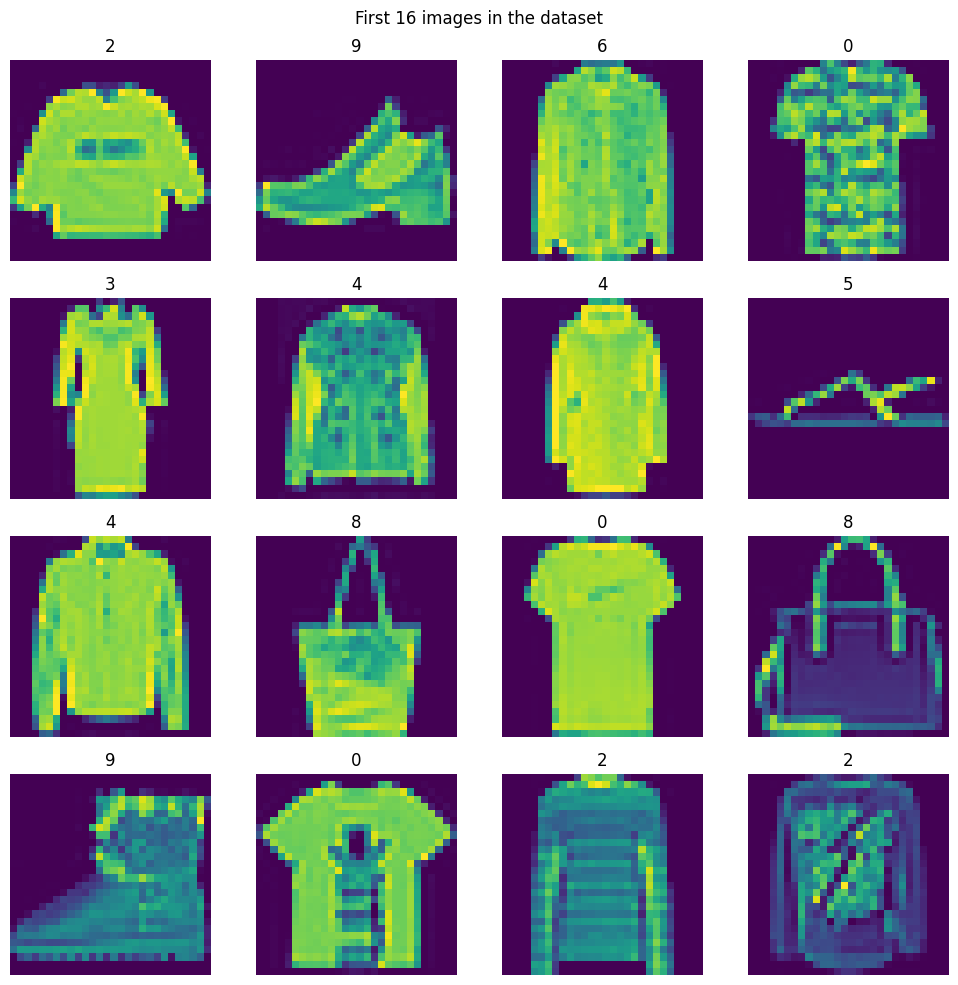

In [ ]:
fig, axis = plt.subplots(4,4, figsize=(10,10))
fig.suptitle('First 16 images in the dataset')

for i , ax in enumerate(axis.flat):
  img = df.iloc[i, 1:].values.reshape(28,28)
  ax.imshow(img)
  ax.axis('off')
  ax.set_title(df.iloc[i,0])

plt.tight_layout()
plt.show()


In [ ]:
X = df.iloc[:,1:].values
y = df.iloc[:,0].values


In [ ]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [ ]:
#Scaling
X_train = X_train / 255.0
X_test = X_test / 255.0

In [ ]:
# CustomDataset

class CustomDataset(Dataset):
  def __init__(self, features, labels):
    self.features = torch.tensor(features, dtype = torch.float32).reshape(-1,1,28,28)
    self.labels = torch.tensor(labels, dtype = torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):
    return self.features[index], self.labels[index]



In [ ]:
# train and test dataset
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test , y_test)

In [ ]:
# define ANN
class MyNN(nn.Module):
  def __init__(self, input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate):

    super().__init__()

    layers = []

    for i in range(num_hidden_layers):
      layers.append(nn.Linear(input_dim, neurons_per_layer))
      layers.append(nn.BatchNorm1d(neurons_per_layer))
      layers.append(nn.ReLU())
      layers.append(nn.Dropout(dropout_rate))
      input_dim = neurons_per_layer

    layers.append(nn.Linear(neurons_per_layer, output_dim))

    self.model= nn.Sequential(*layers)

  def forward(self, x):
    return self.model(x)


In [ ]:
# CNN
class MyNN(nn.Module):
  def __init__(self, input_features):
    super().__init__()

    self.features = nn.Sequential(
        nn.Conv2d(input_features, out_channels=32, kernel_size=3, padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(32, out_channels=64, kernel_size=3, padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(64*7*7,128),
        nn.ReLU(),
        nn.Dropout(p = 0.4),

        nn.Linear(128,64),
        nn.ReLU(),
        nn.Dropout(p = 0.4),

        nn.Linear(64, 10)
    )

  def forward(self, x):
    x = self.features(x)
    x = self.classifier(x)
    return x

In [ ]:
learning_rate = 0.01
epochs = 100

In [ ]:
model = MyNN(1)

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

# Hyperparameter tuning

In [ ]:
def objective(trial):
    # Hyperparameter search space
    num_hidden_layers = trial.suggest_int('num_hidden_layers', 1, 5)
    neurons_per_layer = trial.suggest_int('neurons_per_layer',8,128, step=8)
    epochs = trial.suggest_int('epochs', 10, 100, step = 10)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log = True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5, step = 0.1)
    batch_size = trial.suggest_categorical('batch_size', [16,32, 64, 128])
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD','RMSprop','adamw'])
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-3, log = True)
    # Data loading

    train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, pin_memory = True)
    test_dataloader = DataLoader(test_dataset, batch_size= batch_size, shuffle = False, pin_memory = True)

    # Model initialization
    input_dim = 784
    output_dim = 10

    model = MyNN(input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate)
    model = model.to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()

    if(optimizer_name == 'Adam'):
      optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    elif(optimizer_name == 'adamw'):
      optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif(optimizer_name == 'SGD'):

      optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    else:
      optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Training loop
    for epoch in range(epochs):
        for batch_feature, batch_label in train_dataloader:
            batch_feature = batch_feature.to(device)
            batch_label = batch_label.to(device)

            # Forward pass
            outputs = model(batch_feature)

            # Compute loss
            loss = criterion(outputs, batch_label)

            # Backpropagation and gradient update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Evaluation loop
    model.eval()
    total = 0
    correct = 0

    with torch.no_grad():
        for batch_features, batch_labels in test_dataloader:
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)

            outputs = model(batch_features)
            _, predicted = torch.max(outputs.data, 1)

            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()

    accuracy = correct / total
    return accuracy

In [ ]:
!pip install optuna

In [ ]:
import optuna

study = optuna.create_study(direction = 'maximize')


In [ ]:
study.optimize(objective, n_trials = 50)

In [ ]:
study.best_value

0.8920833333333333

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle = True, pin_memory = True)
test_dataloader = DataLoader(test_dataset, batch_size= 32, shuffle = False, pin_memory = True)

In [ ]:
for epoch in range(epochs):
    for batch_feature, batch_label in train_dataloader:
        batch_feature = batch_feature.to(device)
        batch_label = batch_label.to(device)

        # Forward pass
        outputs = model(batch_feature)

        # Compute loss
        loss = criterion(outputs, batch_label)

        # Backpropagation and gradient update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
model.eval()
total = 0
correct = 0

with torch.no_grad():
    for batch_features, batch_labels in test_dataloader:
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)

        outputs = model(batch_features)
        _, predicted = torch.max(outputs.data, 1)

        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()

accuracy = correct / total

In [ ]:
accuracy

0.828